In [1]:
import scipy
from math import sqrt
from scipy import stats
from numpy import cov, linspace
from statistics import mean
from numpy.random import normal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N):
    A_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    B_before = list(normal(loc=before_mean, scale=before_sigma, size=N))
    A_after  = [x + normal(loc=0, scale=eps_sigma) for x in A_before]
    B_after  = [x + normal(loc=0, scale=eps_sigma) + treatment_lift for x in B_before]
    return A_before, B_before, A_after, B_after

def get_cuped_adjusted(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    theta = cv[0, 1] / cv[1, 1]
    mean_before = mean(A_before + B_before)
    A_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(A_after, A_before)]
    B_after_adjusted = [after - (before - mean_before) * theta for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def get_cuped_adjusted_lr(A_before, B_before, A_after, B_after):
    lr = stats.linregress(A_before + B_before, A_after + B_after)
    mean_after = mean(A_after + B_after)
    A_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(A_after, A_before)]
    B_after_adjusted = [mean_after + after - (lr.intercept + before * lr.slope) for after, before in zip(B_after, B_before)]
    return A_after_adjusted, B_after_adjusted

def lift(A, B):
    return mean(B) - mean(A)

def expected_lift_ratio(A_before, B_before, A_after, B_after):
    cv = cov([A_after + B_after, A_before + B_before])
    corr = cv[0, 1] / (sqrt(cv[0, 0]) * sqrt(cv[1, 1]))
    return 1 - corr**2

def p_value(A, B):
    return stats.ttest_ind(A, B, alternative='greater')[1]

Simulating 10000 A/B tests, true treatment lift is 0...
Traditional    A/B testing, mean lift = -0.01, variance of lift = 5.81
CUPED adjusted A/B testing, mean lift = -0.01, variance of lift = 0.79
Hacked A/B testing, mean lift = 0.88, variance of lift = 2.53


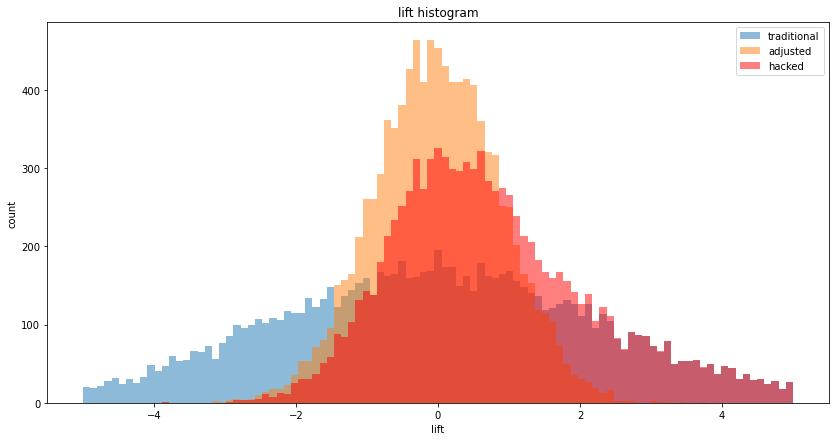

In [3]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 0
num_simulations = 10*1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts, hacked_lifts = [], [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    hacked_lifts.append(max(
        lift(A_after, B_after),
        lift(A_after_adjusted, B_after_adjusted)
    ))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))
print('Hacked A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(hacked_lifts), cov(hacked_lifts)))

bins = linspace(-5, 5, 100)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.hist(hacked_lifts,      bins, alpha=0.5, label='hacked', color='red')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

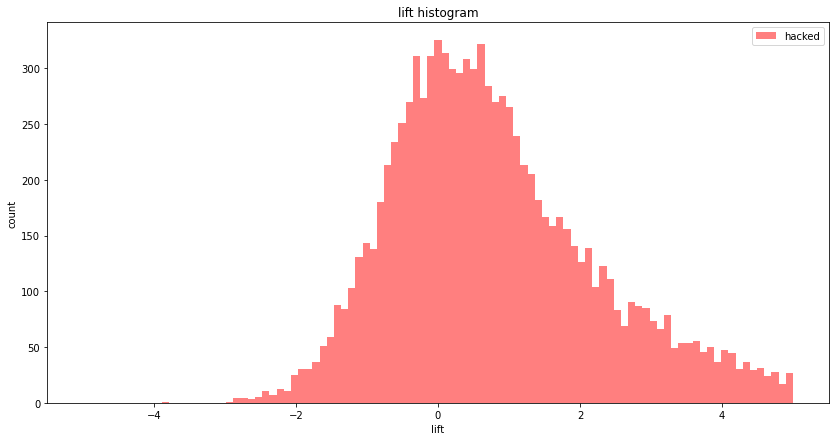

In [4]:
bins = linspace(-5, 5, 100)
plt.figure(figsize=(14, 7))
# plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
# plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.hist(hacked_lifts,      bins, alpha=0.5, label='hacked', color='red')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

In [5]:
N = 1000
before_mean = 100 
before_sigma = 50
eps_sigma = 20
treatment_lift = 0
num_simulations = 10*1000
p_crit = 0.05
traditional_fps, cuped_fps, phack_fps = 0, 0, 0

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    adjusted_pvalue = p_value(A_after_adjusted, B_after_adjusted)
    if p_value(A_after, B_after) < p_crit:
        traditional_fps += 1
    if p_value(A_after_adjusted, B_after_adjusted) < p_crit:
        cuped_fps += 1
    if lift(A_after, B_after) < lift(A_after_adjusted, B_after_adjusted):
        if p_value(A_after, B_after) < p_crit:
            phack_fps += 1
    else:
        if p_value(A_after_adjusted, B_after_adjusted) < p_crit:
            phack_fps += 1

print('False positive rate (expected: %.3f):' % p_crit)
print('Traditional: %.3f' % (traditional_fps/num_simulations))
print('CUPED:       %.3f' % (cuped_fps/num_simulations))
print('p-hacked:    %.3f' % (phack_fps/num_simulations))

Simulating 10000 A/B tests, true treatment lift is 0...
False positive rate (expected: 0.050):
Traditional: 0.051
CUPED:       0.051
p-hacked:    0.075


In [6]:
### no correlation

def get_AB_samples_nocorr(mu, sigma, treatment_lift, N):
    A_before = list(normal(loc=mu, scale=sigma, size=N))
    B_before = list(normal(loc=mu, scale=sigma, size=N))
    A_after  = list(normal(loc=mu, scale=sigma, size=N))
    B_after  = list(treatment_lift + normal(loc=mu, scale=sigma, size=N))
    return A_before, B_before, A_after, B_after

Simulating 1000 A/B tests, true treatment lift is 2...
Traditional    A/B testing, mean lift = 2.00, variance of lift = 5.75
CUPED adjusted A/B testing, mean lift = 1.99, variance of lift = 5.74
CUPED lift variance / tradititional lift variance = 1.00


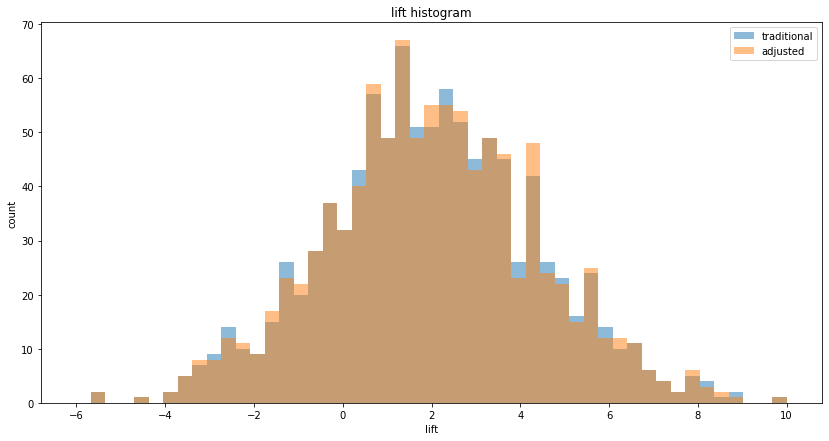

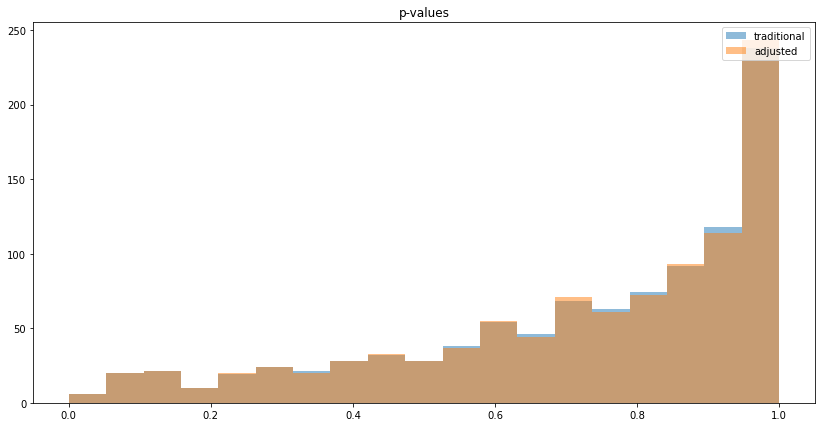

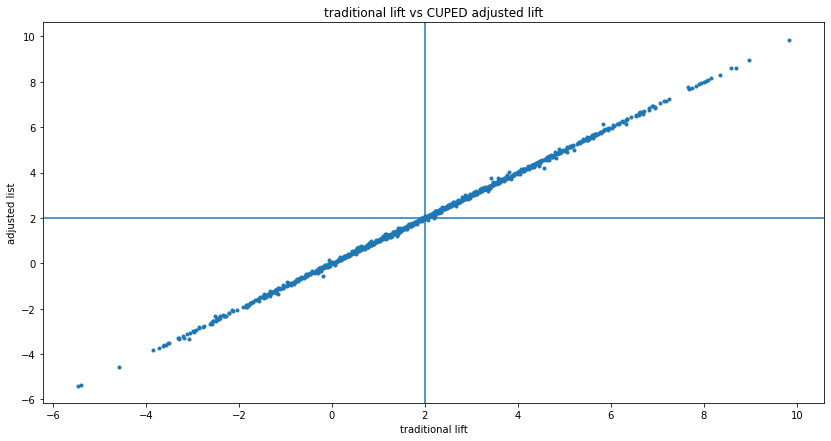

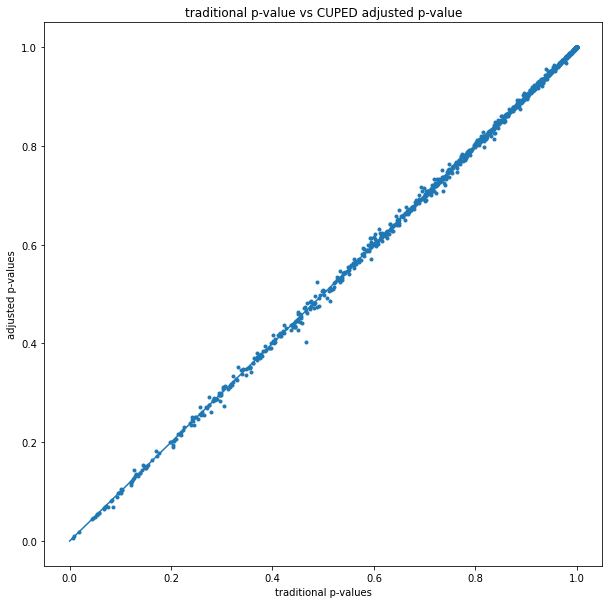

In [7]:
N = 1000
mu = 100 
sigma = 50
treatment_lift = 2
num_simulations = 1000

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(mu, sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    traditional_lifts.append(lift(A_after, B_after))
    adjusted_lifts.append(lift(A_after_adjusted, B_after_adjusted))
    traditional_pvalues.append(p_value(A_after, B_after))
    adjusted_pvalues.append(p_value(A_after_adjusted, B_after_adjusted))
    
print('Traditional    A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(traditional_lifts), cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.2f, variance of lift = %.2f' % (mean(adjusted_lifts), cov(adjusted_lifts)))
print('CUPED lift variance / tradititional lift variance = %.2f' % (cov(adjusted_lifts)/cov(traditional_lifts)))

# large_N = 1000*1000
# A_before, B_before, A_after, B_after = get_AB_samples(before_mean, before_sigma, eps_sigma, treatment_lift, large_N)
# elr = expected_lift_ratio(A_before, B_before, A_after, B_after)
# print('CUPED lift variance / tradititional lift variance = %.2f (expected = %.2f)' % (cov(adjusted_lifts)/cov(traditional_lifts), elr))

bins = linspace(-6, 10, 50)
plt.figure(figsize=(14, 7))
plt.hist(traditional_lifts, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_lifts,    bins, alpha=0.5, label='adjusted')
plt.xlabel('lift')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title('lift histogram')
plt.show()

bins = linspace(0, 1, 20)
plt.figure(figsize=(14, 7))
plt.hist(traditional_pvalues, bins, alpha=0.5, label='traditional')
plt.hist(adjusted_pvalues,    bins, alpha=0.5, label='adjusted')
plt.legend(loc='upper right')
plt.title('p-values')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(traditional_lifts, adjusted_lifts, marker='.')
plt.xlabel('traditional lift')
plt.ylabel('adjusted list')
plt.axvline(x=treatment_lift)
plt.axhline(y=treatment_lift)
plt.title('traditional lift vs CUPED adjusted lift')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1])
plt.scatter(traditional_pvalues, adjusted_pvalues, marker='.')
plt.xlabel('traditional p-values')
plt.ylabel('adjusted p-values')
plt.title('traditional p-value vs CUPED adjusted p-value')
plt.show()

In [8]:
N = 1000
mu = 100 
sigma = 50
treatment_lift = 0
num_simulations = 10000
p_crit = 0.05
traditional_fps, cuped_fps, phack_fps = 0, 0, 0

print('Simulating %s A/B tests, true treatment lift is %d...' % (num_simulations, treatment_lift))

traditional_lifts, adjusted_lifts = [], []
traditional_pvalues, adjusted_pvalues = [], []
for i in range(num_simulations):
    print('%d/%d' % (i, num_simulations), end='\r')
    A_before, B_before, A_after, B_after = get_AB_samples_nocorr(mu, sigma, treatment_lift, N)
    A_after_adjusted, B_after_adjusted = get_cuped_adjusted(A_before, B_before, A_after, B_after)
    adjusted_pvalue = p_value(A_after_adjusted, B_after_adjusted)
    if p_value(A_after, B_after) < p_crit:
        traditional_fps += 1
    if p_value(A_after_adjusted, B_after_adjusted) < p_crit:
        cuped_fps += 1
    if p_value(A_after, B_after) < p_crit or p_value(A_after_adjusted, B_after_adjusted) < p_crit:
        phack_fps += 1

print('False positive rate (expected: %.3f):' % p_crit)
print('Traditional: %.3f' % (traditional_fps/num_simulations))
print('CUPED:       %.3f' % (cuped_fps/num_simulations))
print('p-hacked:    %.3f' % (phack_fps/num_simulations))

Simulating 10000 A/B tests, true treatment lift is 0...
False positive rate (expected: 0.050):
Traditional: 0.052
CUPED:       0.052
p-hacked:    0.053
